In [22]:
# ============================
# 🧠 MLflow Autologging
# ============================

# mlflow.autolog(log_input_examples=True, log_model_signatures=True)
# mlflow.sklearn.autolog() 
# mlflow.sklearn.autolog(
#     log_input_examples=True,
#     log_model_signatures=True,
#     log_post_training_metrics=True,        # calls model.score() → accuracy
#     disable_for_unsupported_versions=True,  # skips if versions still wonky
#     exclusive=True                          # only patch the sklearn integration
# )

2025/04/23 19:03:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [1]:
# RQ1.2: Model Provenance Tracking in Jupyter Notebook using MLflow
# Updated with automatic logging of environment, Git, model config, and FAIR-aligned metadata

# ============================
# ⚙️ Install Dependencies (if needed in Colab)
# ============================
!pip install mlflow scikit-learn pandas numpy matplotlib seaborn shap requests GitPython



In [16]:
!pip install --upgrade threadpoolctl
!pip install setuptools


In [39]:
# ============================
# 📦 Imports
# ============================
import os
import time
import json
import psutil
import platform
import git
from git import Repo
from git import Repo, GitCommandError
import mlflow
import requests
import shap
import pandas as pd
import numpy as np
import sklearn
import subprocess
import seaborn as sns
from git import Repo, GitCommandError
import matplotlib
import matplotlib.pyplot as plt
import mlflow.sklearn
from dotenv import load_dotenv
from datetime import datetime
# import setuptools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, f1_score, roc_curve
)
from mlflow import MlflowClient
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.preprocessing import label_binarize
import numpy as np
import pickle


In [25]:
# ============================
# 📂 Setup MLflow
# ============================
project_dir = os.getcwd()
mlflow.set_tracking_uri("mlrunlogs/mlflow.db")
mlflow.set_experiment("RandomForest-Iris-CSV")

<Experiment: artifact_location='file:///C:/Users/reema/REPO/notebooks/RQ_notebooks/mlrunlogs/mlflow.db/615223710259862608', creation_time=1745329164532, experiment_id='615223710259862608', last_update_time=1745329164532, lifecycle_stage='active', name='RandomForest-Iris-CSV', tags={}>

In [26]:
# ============================
# 🔄 Git Commit Hash
# ============================
repo_dir = "C:/Users/reema/REPO"
previous_commit_repo = git.Repo(repo_dir)
previous_commit_hash = previous_commit_repo.head.object.hexsha

In [27]:
# ============================
# 📥 Load Dataset
# ============================
df = pd.read_csv("../../data/Iris.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [28]:
# ─── 0) Make threadpoolctl safe so MLflow’s autologger won’t crash ───
try:
    import threadpoolctl
    _orig = threadpoolctl.threadpool_info
    def _safe_threadpool_info(*args, **kwargs):
        try:
            return _orig(*args, **kwargs)
        except Exception:
            return []
    threadpoolctl.threadpool_info = _safe_threadpool_info
except ImportError:
    pass  # if threadpoolctl isn’t installed, autolog will skip unsupported versions

# ─── 1) Enable generic autolog (will auto-patch sklearn under the hood) ───
import mlflow
mlflow.autolog(
    log_input_examples=True,
    log_model_signatures=True
)

2025/04/23 19:08:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
C:\Users\reema\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Users\reema\anaconda3

✅ Commit successful.
🚀 Push successful.


<Figure size 600x600 with 0 Axes>

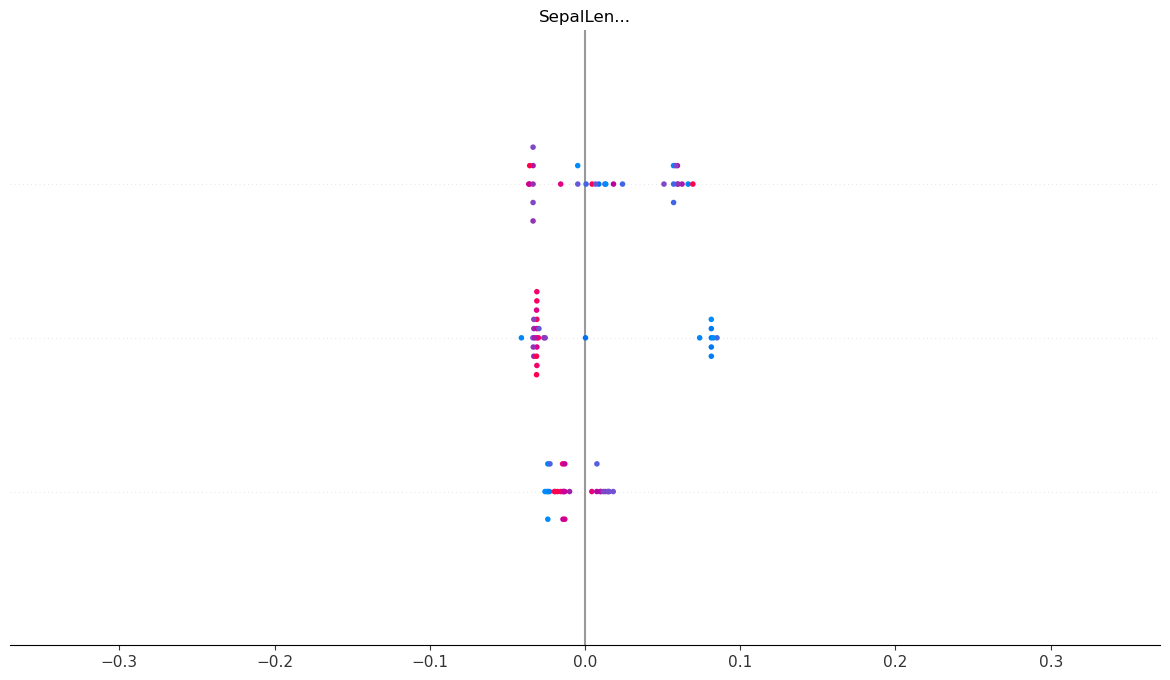

In [41]:

# ============================
# 🚀 Start MLflow Run CURRENT BACKUP
# ============================
with mlflow.start_run() as run:
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"RandomForest_Iris_v{ts}"
    mlflow.set_tag("model_name",model_name)
    
    train_start_ts = datetime.now().isoformat()
    mlflow.set_tag("training_start_time", train_start_ts)

    test_size    = 0.2
    random_state = 42
    # 📈 Model Training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # ── 2) Log dataset split params ──
    mlflow.log_param("test_size", test_size)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_train_samples", X_train.shape[0])
    mlflow.log_param("n_test_samples",  X_test.shape[0])
    mlflow.log_param("n_features",      X_train.shape[1])

     # 1) Define a more complex hyperparameter dict
    hyperparams = {
        "n_estimators":       200,
        "criterion":          "entropy",
        "max_depth":          12,
        "min_samples_split":  5,
        "min_samples_leaf":   2,
        "max_features":       "sqrt",
        "bootstrap":          True,
        "oob_score":          False,
        "class_weight":       None,
        "random_state":       42,
        "verbose":            1,
        "n_jobs":             -1
    }

    # 2) Log them ALL at once
    mlflow.log_params(hyperparams)
    model = RandomForestClassifier(**hyperparams)
    model.fit(X_train, y_train)

    train_end_ts = datetime.now().isoformat()
    mlflow.set_tag("training_end_time", train_end_ts)

     # ── 6) Predict & log metrics ──
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
    prec = precision_score(y_test, y_pred, average="macro")
    rec  = recall_score(y_test,    y_pred, average="macro")
    f1   = f1_score(y_test,      y_pred, average="macro")
    
    mlflow.log_metric("precision_macro", prec)
    mlflow.log_metric("recall_macro",    rec)
    mlflow.log_metric("f1_macro",        f1)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc",   auc)

    # ✅ Log Environment Automatically
    mlflow.log_params({
        "python_version": platform.python_version(),
        "os_platform": f"{platform.system()} {platform.release()}",
        "sklearn_version": sklearn.__version__,
        "pandas_version": pd.__version__,
        "numpy_version": np.__version__,
        "matplotlib_version": matplotlib.__version__,
        "seaborn_version": sns.__version__,
        "shap_version": shap.__version__,
    })

    # ✅ Git and Notebook Metadata
    mlflow.set_tag("notebook_name", "RQ1.ipynb")

    # ✅ Dataset Metadata Tags
    mlflow.set_tag("dataset_name", "Iris") #TODO
    mlflow.set_tag("dataset_version", "1.0.0") #TODO
    mlflow.set_tag("dataset_id", "iris_local") #TODO


    # ─── 2) Create a folder for this run’s plots ───
    plot_dir = os.path.join("plots", model_name)
    os.makedirs(plot_dir, exist_ok=True)

    # 1) Feature Importance Bar Chart
    importances = model.feature_importances_
    # if X_train is a DataFrame, grab column names; otherwise auto-name them f0,f1,...
    try:
        feature_names = X_train.columns
    except AttributeError:
        feature_names = [f"f{i}" for i in range(X_train.shape[1])]
    fi_path = os.path.join(plot_dir, "feature_importances.png")

    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances, y=feature_names)
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(fi_path)
    mlflow.log_artifact(fi_path)
    plt.close()


# 2) Multi-class ROC Curves
# Binarize labels for one-vs-rest
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    for idx, cls in enumerate(classes):
        disp = RocCurveDisplay.from_predictions(
            y_test_bin[:, idx], 
            y_proba[:, idx],
            name=f"ROC for class {cls}"
        )
        roc_path = os.path.join(plot_dir, f"roc_curve_cls_{cls}.png")
        disp.figure_.savefig(roc_path)
        mlflow.log_artifact(roc_path)
        plt.close(disp.figure_)


    # 3) Multi-class Precision-Recall Curves
    for idx, cls in enumerate(classes):
        disp = PrecisionRecallDisplay.from_predictions(
            y_test_bin[:, idx], 
            y_proba[:, idx],
            name=f"PR curve for class {cls}"
        )
        pr_path = os.path.join(plot_dir, f"pr_curve_cls_{cls}.png")
        disp.figure_.savefig(pr_path)
        mlflow.log_artifact(pr_path)
        plt.close(disp.figure_)
        
    # ✅ Confusion Matrix Plot
    cm_path = os.path.join(plot_dir, "confusion_matrix.png")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)

    # ✅ SHAP Summary
    shap_path = os.path.join(plot_dir, "shap_summary.png")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.savefig(shap_path)
    mlflow.log_artifact(shap_path)


    
    # ─── 1) Build a .pkl filename (you can include your model_name for clarity)
    pkl_path = f"{model_name}.pkl"
    
    # ─── 2) Serialize your trained model to disk
    with open(pkl_path, "wb") as f:
        pickle.dump(model, f)
    
    # ─── 3) Log that pickle file as an MLflow artifact
    #     It will appear under Artifacts → models/RandomForest_Iris_vYYYYMMDD_HHMMSS.pkl
    mlflow.log_artifact(pkl_path, artifact_path=model_name)
        
    def get_latest_commit_hash(repo_path="."):
        # returns the full SHA of HEAD
        res = subprocess.run(
            ["git", "-C", repo_path, "rev-parse", "HEAD"],
            capture_output=True, text=True, check=True)
        
        return res.stdout.strip()

    def get_remote_url(repo_path=".", remote="origin"):
        # returns something like git@github.com:user/repo.git or https://...
        res = subprocess.run(
            ["git", "-C", repo_path, "config", "--get", f"remote.{remote}.url"],
            capture_output=True, text=True, check=True
        )
        return res.stdout.strip()
    
    def make_commit_link(remote_url, commit_hash):
        # handle GitHub/GitLab convention; strip “.git” if present
        base = remote_url.rstrip(".git")
        # if SSH form (git@github.com:owner/repo), convert to https
        if base.startswith("git@"):
            base = base.replace(":", "/").replace("git@", "https://")
        return f"{base}/commit/{commit_hash}"

    
    def simple_commit_and_push_and_log(repo_path=".", message="Auto commit", remote="origin", branch="main"):
    # 1) Check for changes
        status = subprocess.run(
            ["git", "-C", repo_path, "status", "--porcelain"],
            capture_output=True, text=True
        )
        if not status.stdout.strip():
            print("🟡 No changes to commit.")
            return None, None
    
        # 2) Stage everything
        add = subprocess.run(
            ["git", "-C", repo_path, "add", "--all"],
            capture_output=True, text=True
        )
        if add.returncode:
            print("❌ git add failed:\n", add.stderr)
            return None, None
    
        # 3) Commit
        commit = subprocess.run(
            ["git", "-C", repo_path, "commit", "-m", message],
            capture_output=True, text=True
        )
        if commit.returncode:
            print("❌ git commit failed:\n", commit.stderr)
            return None, None
        print("✅ Commit successful.")
    
        # 4) Push
        push = subprocess.run(
            ["git", "-C", repo_path, "push", "-u", remote, branch],
            capture_output=True, text=True
        )
        if push.returncode:
            print("❌ git push failed:\n", push.stderr)
        else:
            print("🚀 Push successful.")
    
        # 5) Retrieve hash & remote URL
        sha = get_latest_commit_hash(repo_path)
        url = get_remote_url(repo_path, remote)
        link = make_commit_link(url, sha)
    
        return sha, link
    
      
    sha, link = simple_commit_and_push_and_log(
        repo_path=".",
        message="Auto commit after successful training"
    )
    if sha and link:
        diff_text = subprocess.check_output(
            ["git", "-C", ".", "diff", previous_commit_hash, sha], text=True
        )
                
        # 1) Get your repo’s remote URL and normalize to HTTPS
        remote_url = subprocess.check_output(
            ["git", "config", "--get", "remote.origin.url"],
            text=True
        ).strip().rstrip(".git")
        if remote_url.startswith("git@"):
            # git@github.com:owner/repo.git → https://github.com/owner/repo
            remote_url = remote_url.replace(":", "/").replace("git@", "https://")
        
        # 2) Build commit URLs
        previous_commit_url  = f"{remote_url}/commit/{previous_commit_hash}"
        current_commit_url = f"{remote_url}/commit/{sha}"
        diff_data = {
            "previous_commit":  previous_commit_hash,
            "previous_commit_url":previous_commit_url,
            "current_commit_url":current_commit_url,
            "current_commit": sha,
            "diff": diff_text
        }
        mlflow.log_dict(
            diff_data,
            artifact_file="commit_diff.json"
        )
        mlflow.set_tag("git_previous_commit_hash", previous_commit_hash)
        mlflow.set_tag("git_current_commit_hash", sha)
        mlflow.set_tag("git__current_commit_url", link) 


    client   = MlflowClient()
    run_id    = run.info.run_id
    run_info  = client.get_run(run_id).info
    run_data  = client.get_run(run_id).data
    
    # 1) params, metrics, tags
    params  = dict(run_data.params)
    metrics = dict(run_data.metrics)
    tags    = dict(run_data.tags)

    # (4) List artifacts under a specific subfolder
    # artifact_paths = [af.path for af in client.list_artifacts(run_id)]
    run_meta     = client.get_run(run_id).info
    artifact_uri = run_meta.artifact_uri  # base URI for all artifacts
    
    artifact_meta = []
    
    def _gather(path=""):
        for af in client.list_artifacts(run_id, path):
            # If it’s a directory, recurse
            if af.is_dir:
                _gather(af.path)
                continue
    
            rel_path = af.path
            uri      = f"{artifact_uri}/{rel_path}"
            lower    = rel_path.lower()
    
            # 1) Text files → download & embed contents
            if lower.endswith((".json", ".txt", ".patch")):
                local = client.download_artifacts(run_id, rel_path)
                with open(local, "r", encoding="utf-8") as f:
                    content = f.read()
                artifact_meta.append({
                    "path":    rel_path,
                    "type":    "text",
                    "content": content
                })
    
            # 2) Images → surface a clickable URI
            elif lower.endswith((".png", ".jpg", ".jpeg", ".svg")):
                artifact_meta.append({
                    "path": rel_path,
                    "type": "image",
                    "uri":  uri
                })
    
            # 3) Everything else → just link
            else:
                artifact_meta.append({
                    "path": rel_path,
                    "type": "other",
                    "uri":  uri
                })
    
    # Run the gather
    _gather()
     
    summary = {
        "run_id":         run_id,
        "run_name": run_info.run_name,
        "experiment_id":  run_info.experiment_id,
        "start_time":     run_info.start_time,
        "end_time":       run_info.end_time,
        "params":         params,
        "metrics":        metrics,
        "tags":           tags,
        "artifacts":      artifact_meta
    }
    # 1) Create (or reuse) a base folder for run summaries
    base_dir = "run_summaries"
    os.makedirs(base_dir, exist_ok=True)
    
   # 2) Pick next numeric folder
    existing = [
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.isdigit()
    ]
    next_num = max(map(int, existing), default=0) + 1

    # 1) Determine notebook directory (where your .ipynb lives)
    notebook_dir = os.getcwd()
    
    # 2) Create a subfolder for this model
    folder = os.path.join(notebook_dir, model_name)
    os.makedirs(folder, exist_ok=True)
    
    # 3) Write the summary JSON with model_name in the filename
    json_path = os.path.join(folder, f"{model_name}_run_summary.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)
    
    # 4) (Optional) Log this local JSON into MLflow under 'run_summaries'
    mlflow.log_artifact(json_path, artifact_path=f"run_summaries/{model_name}")
        # 5) Also tag the run with the folder name for easy reference
    mlflow.set_tag("summary_folder", str(next_num))

    mlflow.end_run()

Goal: Notify collaborators who have forked the GitHub repo if their fork is outdated (i.e., behind the current commit used to train a model).

🧠 What We Need
Current training run’s Git commit hash

GitHub API to fetch all forks of your repo

Compare each fork’s main or master branch head commit

Create an issue on their fork or on your repo tagging them if they’re behind

Option 1 (Practical): Notify via issues on your own repo

In [ ]:
import requests
import os
from dotenv import load_dotenv

def notify_outdated_forks():
    load_dotenv()
    token     = os.getenv("THESIS_TOKEN")
    owner     = "reema-dass26"
    repo      = "REPO"

    if not token:
        print("⚠️ GITHUB_TOKEN not set.")
        return

    headers = {
        "Authorization": f"token {token}",
        "Accept":        "application/vnd.github.v3+json"
    }

    # 1) Get latest upstream commit
    main_commits = requests.get(
        f"https://api.github.com/repos/{owner}/{repo}/commits",
        headers=headers,
        params={"per_page": 1}
    )
    main_commits.raise_for_status()
    new_commit_hash = main_commits.json()[0]["sha"]
    print(f"Latest upstream commit: {new_commit_hash}")

    # 2) List forks
    forks_resp = requests.get(f"https://api.github.com/repos/{owner}/{repo}/forks", headers=headers)
    forks_resp.raise_for_status()
    forks = forks_resp.json()

    # 3) Compare each fork
    outdated = []
    for fork in forks:
        fork_owner = fork["owner"]["login"]
        fork_comm = requests.get(
            fork["url"] + "/commits",
            headers=headers,
            params={"per_page": 1}
        )
        if fork_comm.status_code != 200:
            print(f"  – could not fetch commits for {fork_owner}, skipping.")
            continue

        fork_sha = fork_comm.json()[0]["sha"]
        if fork_sha != new_commit_hash:
            outdated.append(f"@{fork_owner}")

    # 4) Open an issue if any are behind
    if outdated:
        title = "🔔 Notification: Your fork is behind the latest commit"
        body  = (
            f"Hi {' '.join(outdated)},\n\n"
            f"The main repository has been updated to commit `{new_commit_hash}`.\n"
            "Please consider pulling the latest changes to stay in sync.\n\n"
            "Thanks!"
        )
        issues_url = f"https://api.github.com/repos/{owner}/{repo}/issues"
        resp = requests.post(
        issues_url,
        headers=headers,
        json={"title": title, "body": body}
    )

    # DEBUGGING OUTPUT
    print(f"→ POST {issues_url}")
    print("→ Status code:", resp.status_code)
    print("→ Response headers:", resp.headers)
    try:
        data = resp.json()
        print("→ Response JSON:", data)
        print("→ html_url field:", data.get("html_url"))
    except ValueError:
        print("→ No JSON response body; raw text:", resp.text)

if __name__ == "__main__":
    answer = input("Do you want to notify collaborators whose forks are behind? (y/N): ").strip().lower()
    if answer in ("y", "yes"):
        notify_outdated_forks()
    else:
        print("No action taken.")


C:\Users\reema\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Users\reema\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:761: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


✅ Commit successful.
🚀 Push successful.


<Figure size 600x600 with 0 Axes>

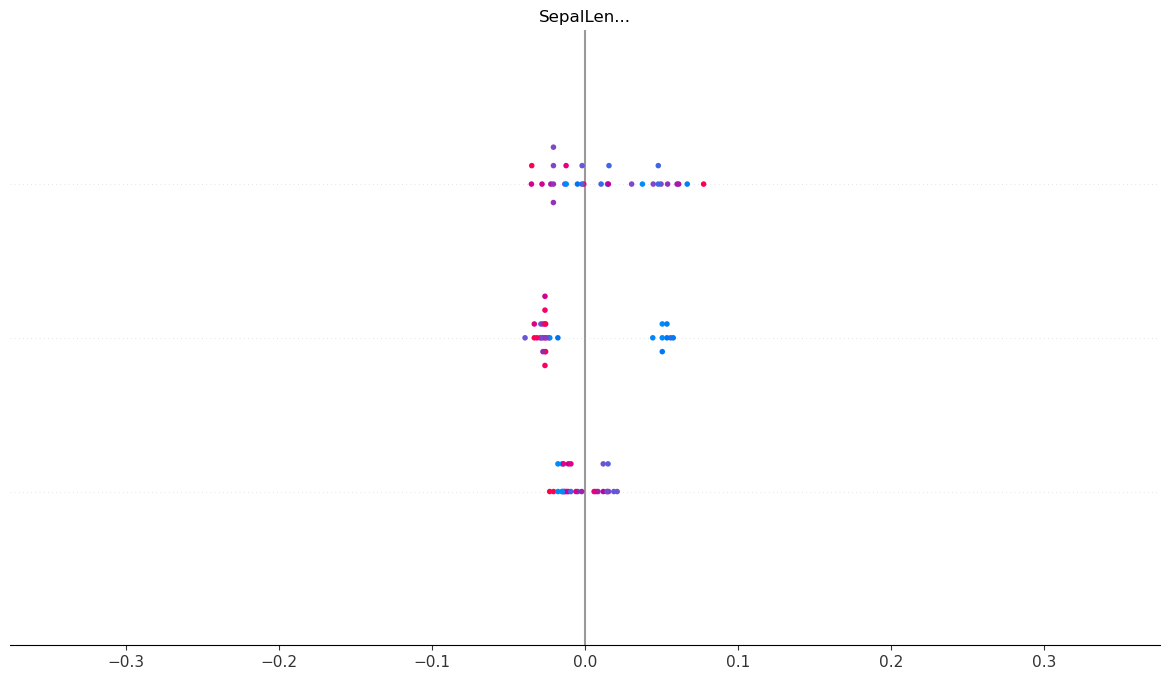

In [21]:
# # ============================
# # 🚀 Start MLflow Run CURRENT BACKUP
# # ============================
# with mlflow.start_run() as run:
#     model_name = f"RandomForest_Iris_v1.0.0"
#     training_time_start = time.time()

#     # 📈 Model Training
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     model = RandomForestClassifier(n_estimators=100, random_state=42)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_proba = model.predict_proba(X_test)
#     acc = accuracy_score(y_test, y_pred)
#     auc = roc_auc_score(y_test, y_proba, multi_class="ovr")

#     # ✅ Log Environment Automatically
#     mlflow.log_params({
#         "python_version": platform.python_version(),
#         "os_platform": f"{platform.system()} {platform.release()}",
#         "sklearn_version": sklearn.__version__,
#         "pandas_version": pd.__version__,
#         "numpy_version": np.__version__,
#         "matplotlib_version": matplotlib.__version__,
#         "seaborn_version": sns.__version__,
#         "shap_version": shap.__version__,
#     })

#     # ✅ Git and Notebook Metadata
#     mlflow.set_tag("notebook_name", "RQ1.ipynb")

#     # ✅ Dataset Metadata Tags
#     mlflow.set_tag("dataset_name", "Iris") #TODO
#     mlflow.set_tag("dataset_version", "1.0.0") #TODO
#     mlflow.set_tag("dataset_id", "iris_local") #TODO

#     # ✅ Confusion Matrix Plot
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(6, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     cm_path = "confusion_matrix.png"
#     plt.savefig(cm_path)
#     mlflow.log_artifact(cm_path)

#     # ✅ SHAP Summary
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test)
#     shap.summary_plot(shap_values, X_test, show=False)
#     shap_path = "shap_summary.png"
#     plt.savefig(shap_path)
#     mlflow.log_artifact(shap_path)


#     def get_latest_commit_hash(repo_path="."):
#         # returns the full SHA of HEAD
#         res = subprocess.run(
#             ["git", "-C", repo_path, "rev-parse", "HEAD"],
#             capture_output=True, text=True, check=True
        
#         return res.stdout.strip()

#     def get_remote_url(repo_path=".", remote="origin"):
#         # returns something like git@github.com:user/repo.git or https://...
#         res = subprocess.run(
#             ["git", "-C", repo_path, "config", "--get", f"remote.{remote}.url"],
#             capture_output=True, text=True, check=True
#         )
#         return res.stdout.strip()
    
#     def make_commit_link(remote_url, commit_hash):
#         # handle GitHub/GitLab convention; strip “.git” if present
#         base = remote_url.rstrip(".git")
#         # if SSH form (git@github.com:owner/repo), convert to https
#         if base.startswith("git@"):
#             base = base.replace(":", "/").replace("git@", "https://")
#         return f"{base}/commit/{commit_hash}"

    
#     def simple_commit_and_push_and_log(repo_path=".", message="Auto commit", remote="origin", branch="main"):
#     # 1) Check for changes
#         status = subprocess.run(
#             ["git", "-C", repo_path, "status", "--porcelain"],
#             capture_output=True, text=True
#         )
#         if not status.stdout.strip():
#             print("🟡 No changes to commit.")
#             return None, None
    
#         # 2) Stage everything
#         add = subprocess.run(
#             ["git", "-C", repo_path, "add", "--all"],
#             capture_output=True, text=True
#         )
#         if add.returncode:
#             print("❌ git add failed:\n", add.stderr)
#             return None, None
    
#         # 3) Commit
#         commit = subprocess.run(
#             ["git", "-C", repo_path, "commit", "-m", message],
#             capture_output=True, text=True
#         )
#         if commit.returncode:
#             print("❌ git commit failed:\n", commit.stderr)
#             return None, None
#         print("✅ Commit successful.")
    
#         # 4) Push
#         push = subprocess.run(
#             ["git", "-C", repo_path, "push", "-u", remote, branch],
#             capture_output=True, text=True
#         )
#         if push.returncode:
#             print("❌ git push failed:\n", push.stderr)
#         else:
#             print("🚀 Push successful.")
    
#         # 5) Retrieve hash & remote URL
#         sha = get_latest_commit_hash(repo_path)
#         url = get_remote_url(repo_path, remote)
#         link = make_commit_link(url, sha)
    
#         return sha, link
    
      
#     sha, link = simple_commit_and_push_and_log(
#         repo_path=".",
#         message="Auto commit after successful training"
#     )
#     if sha and link:
#         diff_text = subprocess.check_output(
#             ["git", "-C", ".", "diff", previous_commit_hash, sha], text=True
#         )
                
#         # 1) Get your repo’s remote URL and normalize to HTTPS
#         remote_url = subprocess.check_output(
#             ["git", "config", "--get", "remote.origin.url"],
#             text=True
#         ).strip().rstrip(".git")
#         if remote_url.startswith("git@"):
#             # git@github.com:owner/repo.git → https://github.com/owner/repo
#             remote_url = remote_url.replace(":", "/").replace("git@", "https://")
        
#         # 2) Build commit URLs
#         previous_commit_url  = f"{remote_url}/commit/{previous_commit_hash}"
#         current_commit_url = f"{remote_url}/commit/{sha}"
#         diff_data = {
#             "previous_commit":  previous_commit_hash,
#             "previous_commit_url":previous_commit_url,
#             "current_commit_url":current_commit_url,
#             "current_commit": sha,
#             "diff": diff_text
#         }
#         mlflow.log_dict(
#             diff_data,
#             artifact_file="commit_diff.json"
#         )
#         mlflow.set_tag("git_previous_commit_hash", previous_commit_hash)
#         mlflow.set_tag("git_current_commit_hash", sha)
#         mlflow.set_tag("git__current_commit_url", link) 


#     client   = MlflowClient()
#     run_id    = run.info.run_id
#     run_info  = client.get_run(run_id).info
#     run_data  = client.get_run(run_id).data
    
#     # 1) params, metrics, tags
#     params  = dict(run_data.params)
#     metrics = dict(run_data.metrics)
#     tags    = dict(run_data.tags)

#     # (4) List artifacts under a specific subfolder
#     artifact_paths = [af.path for af in client.list_artifacts(run_id)]
    
#     # # 2) recursively gather all artifact paths
#     # artifact_paths = []
#     # def _gather(path=""):
#     #     for af in client.list_artifacts(run_id, path):
#     #         if af.is_dir:
#     #             _gather(af.path)
#     #         else:
#     #             artifact_paths.append(af.path)
#     # _gather()

#     # 3) assemble summary
#     summary = {
#         "run_id":         run_id,
#         "run_name": run_info.run_name,
#         "experiment_id":  run_info.experiment_id,
#         "start_time":     run_info.start_time,
#         "end_time":       run_info.end_time,
#         "params":         params,
#         "metrics":        metrics,
#         "tags":           tags,
#         "artifacts":      artifact_paths
#     }
#     # 1) Create (or reuse) a base folder for run summaries
#     base_dir = "run_summaries"
#     os.makedirs(base_dir, exist_ok=True)
    
#    # 2) Pick next numeric folder
#     existing = [
#         d for d in os.listdir(base_dir)
#         if os.path.isdir(os.path.join(base_dir, d)) and d.isdigit()
#     ]
#     next_num = max(map(int, existing), default=0) + 1

#     mlflow.log_dict(
#         summary,
#         artifact_file=f"run_summaries/{next_num}/run_summary.json"
#     )
#     # 3) Save the summary JSON into that folder
#     # local_path = os.path.join(run_folder, "run_summary.json")
#     # with open(local_path, "w") as f:
#     #     json.dump(summary, f, indent=2)
#     # # 4) (Optional) Mirror it into MLflow artifacts under the same counter path
#     # mlflow.log_artifact(local_path, artifact_path=f"run_summaries/{next_num}")
    
#     # 5) Also tag the run with the folder name for easy reference
#     mlflow.set_tag("summary_folder", str(next_num))
#         # with open("model_metadata_fair4ml.json", "w") as f:
#     #     json.dump(fair4ml_metadata, f, indent=2)
#     # mlflow.log_artifact("model_metadata_fair4ml.json")

#     mlflow.end_run()

In [8]:
# # ============================
# # 🚀 Start MLflow Run
# # ============================
# with mlflow.start_run() as run:
#     model_name = f"RandomForest_Iris_v1.0.0"
#     training_time_start = time.time()

#     # 📈 Model Training
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     model = RandomForestClassifier(n_estimators=100, random_state=42)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_proba = model.predict_proba(X_test)
#     acc = accuracy_score(y_test, y_pred)
#     auc = roc_auc_score(y_test, y_proba, multi_class="ovr")

#     # ✅ Log Environment Automatically
#     mlflow.log_params({
#         "python_version": platform.python_version(),
#         "os_platform": f"{platform.system()} {platform.release()}",
#         "sklearn_version": sklearn.__version__,
#         "pandas_version": pd.__version__,
#         "numpy_version": np.__version__,
#         "matplotlib_version": matplotlib.__version__,
#         "seaborn_version": sns.__version__,
#         "shap_version": shap.__version__,
#     })

#     # ✅ Git and Notebook Metadata
#     mlflow.set_tag("git_commit_hash", commit_hash)
#     mlflow.set_tag("notebook_name", "RQ1.ipynb")

#     # ✅ Dataset Metadata Tags
#     mlflow.set_tag("dataset_name", "Iris")
#     mlflow.set_tag("dataset_version", "1.0.0")
#     mlflow.set_tag("dataset_id", "iris_local")

#     # ✅ Confusion Matrix Plot
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(6, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     cm_path = "confusion_matrix.png"
#     plt.savefig(cm_path)
#     mlflow.log_artifact(cm_path)

#     # ✅ SHAP Summary
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test)
#     shap.summary_plot(shap_values, X_test, show=False)
#     shap_path = "shap_summary.png"
#     plt.savefig(shap_path)
#     mlflow.log_artifact(shap_path)

#     # ✅ FAIR4ML-style Metadata JSON
#     fair4ml_metadata = {
#         "@type": "MLModel",
#         "name": model_name,
#         "algorithm": "RandomForestClassifier",
#         "hyperParameters": model.get_params(),
#         "trainingDataset": {
#             "name": "Iris",
#             "version": "1.0.0",
#             "identifier": "iris_local"
#         },
#         "trainingMetrics": {
#             "accuracy": acc,
#             "roc_auc": auc,
#             "precision": precision_score(y_test, y_pred, average='macro'),
#             "recall": recall_score(y_test, y_pred, average='macro'),
#             "f1_score": f1_score(y_test, y_pred, average='macro')
#         },
#         "environment": {
#             "python": platform.python_version(),
#             "os": f"{platform.system()} {platform.release()}",
#             "libraries": {
#                 "sklearn": sklearn.__version__,
#                 "pandas": pd.__version__,
#                 "numpy": np.__version__
#             }
#         },
#         "source": {
#             "git_commit": commit_hash,
#             "notebook": "RQ1.ipynb"
#         }
#     }

#     # ─── UPDATE: Save FAIR4ML metadata as artifact (already in place)
#     with open("model_metadata_fair4ml.json", "w") as f:
#         json.dump(fair4ml_metadata, f, indent=2)
#     mlflow.log_artifact("model_metadata_fair4ml.json")

#     # ← NEW: Import PROV‑O library for RQ1.2
#     from prov.model import ProvDocument, Namespace, PROV

#     # ← NEW: Build PROV‑O document for the training run (RQ1.2)
#     prov = ProvDocument()
#     ex = Namespace("ex", "http://example.org/")
#     prov.add_namespace(ex)

#     # ← NEW: Define entities and activity
#     data_ent = prov.entity(ex["dataset/iris"], {
#         "prov:label": "Iris Dataset",
#         "ex:split": "80/20"
#     })
#     model_ent = prov.entity(ex[f"model/{run.info.run_id}"], {
#         "prov:label": "RandomForestClassifier",
#         "ex:params": json.dumps(model.get_params())
#     })
#     act_train = prov.activity(
#         ex[f"activity/train/{run.info.run_id}"],
#         None, None,
#         {"prov:label": "Model training",
#          "ex:startTime": run.info.start_time,
#          "ex:endTime": run.info.end_time}
#     )
#     prov.wasGeneratedBy(model_ent, act_train)
#     prov.used(act_train, data_ent)

#     # ← NEW: Serialize & log PROV‑O JSON‑LD artifact
#     prov_path = "model_provenance.jsonld"
#     with open(prov_path, "w") as f:
#         f.write(prov.serialize(indent=2))
#     mlflow.log_artifact(prov_path)

#     # (your existing git‐commit & push helpers unchanged…)

#     sha, link = simple_commit_and_push_and_log(
#         repo_path=".",
#         message="Auto commit after successful training"
#     )
#     if sha and link:
#         mlflow.set_tag("git_commit_hash", sha)
#         mlflow.set_tag("git_commit_url", link)

#     mlflow.end_run()

# # ← NEW: RQ2 helper functions for auditing and reproducibility checks

# def trace_run_provenance(run_id):
#     """Print key metadata and artifacts for a given MLflow run."""
#     from mlflow.tracking import MlflowClient
#     client = MlflowClient()
#     run = client.get_run(run_id)
#     print(f"📝 Run {run_id} provenance:")
#     print("  • Git SHA:", run.data.tags.get("git_commit_hash"))
#     print("  • Commit URL:", run.data.tags.get("git_commit_url"))
#     print("  • Dataset split:", run.data.tags.get("dataset_split"))
#     print("  • Metrics:", run.data.metrics)
#     print("  • Artifacts:", [a.path for a in client.list_artifacts(run_id)])

# def detect_deprecated_code(run_id, grace_days=7):
#     """
#     Check if the run's commit is older than origin/main by > grace_days.
#     """
#     import subprocess
#     from mlflow.tracking import MlflowClient
#     client = MlflowClient()
#     run = client.get_run(run_id)
#     sha = run.data.tags.get("git_commit_hash")
#     main_ts = int(subprocess.check_output(
#         ["git", "log", "-1", "--format=%ct", "origin/main"]
#     ).strip())
#     run_ts = int(subprocess.check_output(
#         ["git", "log", "-1", "--format=%ct", sha]
#     ).strip())
#     age = (main_ts - run_ts) / 86400
#     status = "⚠️" if age > grace_days else "✅"
#     print(f"{status} Run {run_id} is {age:.1f} days behind main.")

# # ─── USAGE:
# # After you execute your training cell, you can call:
# # trace_run_provenance(<run_id>)
# # detect_deprecated_code(<run_id>, grace_days=5)
